В данной работе разбирается и изучается соревнование на Kaggle.com
[Homesite Quote Conversion](https://www.kaggle.com/c/homesite-quote-conversion/overview)

Обзор данных и задач соревнования:
цель соревнования - создать модель предложения страхования жилья, которая приведет к покупке страхового полиса.

Используя анонимизированную базу данных информации о деятельности клиентов и продаж, включая информацию об имуществе и издержках, Homesite бросает вам вызов, чтобы предсказать, какие клиенты будут покупать страховку. 

Разбор задачи основан на решении победителя конкурса Far0n и членов его команды:
https://github.com/Far0n/kaggle-homesite  

In [62]:
from itertools import chain
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import pandas as pd
import xgboost as xgb
from PIL import Image
from IPython.display import display
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")


# ссылки на данные
train_file = "train.csv"
test_file = "test.csv"
sample_submission = "sample_submission.csv"
submission_filename = "god_of_overfitting_spare_us.csv"

# Загрузка данных

In [10]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
y_train = train.QuoteConversion_Flag

In [11]:
train.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,...,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,...,18,22,-1,10,-1,11,-1,12,N,IL


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260753 entries, 0 to 260752
Columns: 299 entries, QuoteNumber to GeographicField64
dtypes: float64(6), int64(265), object(28)
memory usage: 594.8+ MB


In [13]:
# удаляю ненужные поля: порядковый номер и целевой признак из 
# тренировочного датасета
train = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
test = test.drop('QuoteNumber', axis=1)

# определяю длину тренировочного датасета (кол-во строк)
ntrain = train.shape[0]
# объединяю тренировочный и тестовый набор данных вместе
# для совместных преобразований данных
train_test = pd.concat((train, test), axis=0)

# преобразую строчные значения даты в вормат времени datetime
train_test['Date'] = pd.to_datetime(train_test['Original_Quote_Date'])
# добавляю новые числовые признаки связанные с датой
train_test['Year'] = train_test['Date'].dt.year
train_test['Month'] = train_test['Date'].dt.month
train_test['Day'] = train_test['Date'].dt.day
train_test['Weekday'] = train_test['Date'].dt.dayofweek

# убираю запятую из строчного признака и конвертирую его в целое число
train_test['Field10'] = train_test['Field10'].apply(lambda x:
                                x.replace(',', '')).astype(np.int32)


In [14]:
# проверяю пропуски в данных
dataframe=train_test
lst=[]
for col in dataframe.columns:
	# count number of rows with missing values
	n_miss = dataframe[col].isnull().sum()
	perc = n_miss / dataframe.shape[0] * 100
	if n_miss>0:
		lst.append(col)        
	print('> %s, Missing: %d (%.1f%%)' % (col, n_miss, perc))

> Original_Quote_Date, Missing: 0 (0.0%)
> Field6, Missing: 0 (0.0%)
> Field7, Missing: 0 (0.0%)
> Field8, Missing: 0 (0.0%)
> Field9, Missing: 0 (0.0%)
> Field10, Missing: 0 (0.0%)
> Field11, Missing: 0 (0.0%)
> Field12, Missing: 0 (0.0%)
> CoverageField1A, Missing: 0 (0.0%)
> CoverageField1B, Missing: 0 (0.0%)
> CoverageField2A, Missing: 0 (0.0%)
> CoverageField2B, Missing: 0 (0.0%)
> CoverageField3A, Missing: 0 (0.0%)
> CoverageField3B, Missing: 0 (0.0%)
> CoverageField4A, Missing: 0 (0.0%)
> CoverageField4B, Missing: 0 (0.0%)
> CoverageField5A, Missing: 0 (0.0%)
> CoverageField5B, Missing: 0 (0.0%)
> CoverageField6A, Missing: 0 (0.0%)
> CoverageField6B, Missing: 0 (0.0%)
> CoverageField8, Missing: 0 (0.0%)
> CoverageField9, Missing: 0 (0.0%)
> CoverageField11A, Missing: 0 (0.0%)
> CoverageField11B, Missing: 0 (0.0%)
> SalesField1A, Missing: 0 (0.0%)
> SalesField1B, Missing: 0 (0.0%)
> SalesField2A, Missing: 0 (0.0%)
> SalesField2B, Missing: 0 (0.0%)
> SalesField3, Missing: 0 (0.0%)

In [15]:
print('Колонки с пропущенными значениями: ')
lst

Колонки с пропущенными значениями: 


['PersonalField7',
 'PersonalField84',
 'PropertyField3',
 'PropertyField4',
 'PropertyField5',
 'PropertyField29',
 'PropertyField30',
 'PropertyField32',
 'PropertyField34',
 'PropertyField36',
 'PropertyField38']

In [19]:
# смотрю, какие данные пропущены
print('Значения поля {}:, {}'.format('PersonalField7', train_test['PersonalField7'].unique()))
print('Значения поля {}:, {}'.format('PersonalField84', train_test['PersonalField84'].unique()))
print('Значения поля {}:, {}'.format('PropertyField3', train_test['PropertyField3'].unique()))
print('Значения поля {}:, {}'.format('PropertyField4', train_test['PropertyField4'].unique()))
print('Значения поля {}:, {}'.format('PropertyField5', train_test['PropertyField5'].unique()))
print('Значения поля {}:, {}'.format('PropertyField29', train_test['PropertyField29'].unique()))
print('Значения поля {}:, {}'.format('PropertyField30', train_test['PropertyField30'].unique()))
print('Значения поля {}:, {}'.format('PropertyField32', train_test['PropertyField32'].unique()))
print('Значения поля {}:, {}'.format('PropertyField34', train_test['PropertyField34'].unique()))
print('Значения поля {}:, {}'.format('PropertyField36', train_test['PropertyField36'].unique()))
print('Значения поля {}:, {}'.format('PropertyField38', train_test['PropertyField38'].unique()))

Значения поля PersonalField7:, ['N' 'Y' nan]
Значения поля PersonalField84:, [ 2. nan  1.  5.  4.  7.  8.  3.]
Значения поля PropertyField3:, ['N' 'Y' nan]
Значения поля PropertyField4:, ['N' 'Y' nan]
Значения поля PropertyField5:, ['Y' 'N' nan]
Значения поля PropertyField29:, [ 0. nan  1. 10.]
Значения поля PropertyField30:, ['N' 'Y' nan]
Значения поля PropertyField32:, ['Y' 'N' nan]
Значения поля PropertyField34:, ['Y' 'N' nan]
Значения поля PropertyField36:, ['N' 'Y' nan]
Значения поля PropertyField38:, ['N' 'Y' nan]


Видно что два поля имеют числовые значения, причем нехватка данных довольно значительная: 47-77%, остальные - строчные.
Можно было бы удалить данные, где нехватает большинство значений и заменить отсутствующие строчные каким нибудь статистическим значением, но автор пошел другим путем: он присвоил пропущенным значениям -1 с целью использовать этот трюк для создания новых признаков в дальнейшем, по всей видимости, для оценки веса входящих значений. 

In [20]:
# заменяю пропуск на -1
train_test['PropertyField37'] = train_test['PropertyField37'].apply(lambda x: -1 if x == ' ' else x)
train_test['GeographicField10AraphicField63'] = train_test['GeographicField63'].apply(lambda x: -1 if x == ' ' else x)

# удаляю временнЫе поля 
train_test = train_test.drop(['Date', 'Original_Quote_Date'], axis=1)
# заменяю пропущенные значения -1
train_test = train_test.fillna(-1)

In [21]:
# определяю данные с категориального (строкового типа)
# и делаю Label encoder
categoricals = [x for x in train_test.columns if train_test[x].dtype == 'object']
for c in categoricals:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_test[c].values))
        train_test[c] = lbl.transform(list(train_test[c].values))

Некоторые участники соревнования делали здесь One Hot encoder, но так как в дальнейшем будет использоваться модель XGboost, которая не чувствительна к стандартизации и скалированию, это не столь важно.

In [22]:
# разделяю выборки опять на тренировочную и тестовую
train = train_test.iloc[:ntrain, :].copy().reset_index(drop=True)
test = train_test.iloc[ntrain:, :].copy().reset_index(drop=True)

На этом как бы подготовительный этап почти закончен, далее начинаем работать с признаками. 

Как отмечала команда Faronа в обсуждениях к соревнованиям они потратили многие недели на обработку данных, создали более 600 моделей:
  Xgbs, Nns(lasagne and keras), Rfs, Adaboosts, svms, ETs, Logits, Libfms , vowpal  
Использовали различные входные типы данных: только числовые, только категориальные, смешанные.
Использовали различный отбор признаков: прямой, обратный, смешанный.
И множество субмоделей с половиной признаков: модели за каждую неделю, каждый год и так далее.
После этого они применили метамодель (ансамбль) из 3-х уровней с различным отбором признаков и выбором моделей.

Ну на этом всем останавливаться не будем, потому что задачи такой нет. А есть задача рассмотреть лучшую одиночную модель конкурса Farona.

# Выделение важных признаков и конструирование новых

## Выделение важных признаков

Так как эта задача будет решаться с помощью XGB бустинга начнем с выделения важнейших признаков.

Для наглядности и сокращения времени расчетов я не буду делать все вычесления на полном датасете, а возьму выборку из первых 10000 строк. 
Ибо из-за большого объема данных полный перебор ,бустингом может занять недели, как у автора.

Мое решение может несколько отличаться от решения автора, еще потому что Faron для выделения признаков, а именно конкретно их взаимодействия, пользовался собственной разработанной библиотекой, не все возможности которой публично доступны.

https://github.com/Far0n/xgbfi

Но кое что от-туда можно поиметь для сравнения

In [23]:
!pip install xgbfir

In [24]:
import xgbfir

In [25]:
X=train.iloc[:100000,:]
Y=y_train[:100000]
# здесь я беру параметры установленные автором
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': .85,
    'eta': 0.0275,
    'objective': 'binary:logitraw',
    'num_parallel_tree': 7,
    'max_depth': 5,
    'nthread': 22,
    'eval_metric': 'auc',
}

Ищу первые 111 признаков наиболее важных в модели

In [29]:
clf=xgb.XGBClassifier(xgb_params=xgb_params)
clf.fit(X, Y)
dict_scores=clf.get_booster().get_score(importance_type="gain")
# сортирую признаки
sc_sorted={k: v for k, v in sorted(dict_scores.items(), 
                    key=lambda item: item[1], reverse=True)}
list_best=list(sc_sorted)[:111]

In [30]:
print('Список первых 111 самых важных признаков',list_best)

Список первых 111 самых важных признаков ['PropertyField37', 'SalesField5', 'PersonalField2', 'PersonalField9', 'PropertyField29', 'PersonalField1', 'GeographicField8A', 'PersonalField82', 'PropertyField34', 'SalesField1B', 'SalesField1A', 'PersonalField13', 'CoverageField8', 'PersonalField26', 'PersonalField27', 'SalesField4', 'PropertyField35', 'PersonalField11', 'PersonalField84', 'SalesField10', 'PersonalField12', 'SalesField3', 'PersonalField10B', 'PersonalField28', 'GeographicField21B', 'PersonalField45', 'Field7', 'CoverageField6A', 'GeographicField14B', 'PropertyField3', 'GeographicField9A', 'SalesField9', 'SalesField6', 'GeographicField19B', 'GeographicField5B', 'SalesField2B', 'GeographicField11B', 'GeographicField21A', 'PropertyField33', 'PersonalField76', 'GeographicField8B', 'Field12', 'PersonalField24', 'PersonalField75', 'PersonalField57', 'PropertyField32', 'GeographicField6B', 'PropertyField1B', 'GeographicField13B', 'PropertyField39B', 'PersonalField79', 'SalesField7'

Здесь стоит обратить внимание на параметр 'gain' в важности признака, это информациионный параметр, который применяется в классификации, в регрессии учитывается 'weight'.

Теперь посмотрим, что получится выделить с помощью авторской оригинальной программы.

In [34]:
# используя уже обученную модель сохраняем важнейшие признаки в excel файл на диске
xgbfir.saveXgbFI(clf, feature_names=np.array(list(X.columns)), OutputXlsxFile='housingFI.xlsx')

In [35]:
data=pd.read_excel('housingFI.xlsx')
data.head()

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,PropertyField37,33011.889971,32,18.246878,0.570215,1031.621562,12657.462360,1,30,4,2,1,2,6.666667,17.500000,2.500000
1,SalesField5,26603.265052,64,16.022700,0.250355,415.676016,26040.697781,2,4,5,15,2,1,4.833333,35.734375,3.062500
2,PersonalField9,17597.970709,83,34.606145,0.416942,212.023743,8603.239747,3,2,1,5,4,3,3.000000,19.843373,2.746988
3,PropertyField29,8878.179081,51,22.288530,0.437030,174.081943,5487.555948,4,8,3,4,5,4,4.666667,9.000000,1.764706
4,PersonalField2,5765.212870,15,5.115948,0.341063,384.347525,1270.362493,5,92,27,7,3,7,23.500000,27.400000,3.466667


Проверяю совпадение признаков в двух списках:

In [36]:
top111fir=list(data.Interaction)
sum([x in top111fir for x in list_best])

56

Видно, что не все совпало, очевидно, что автор использует другие подходы.

Таким же образом выделяю 73 самых слабых признака:
    

In [37]:
list_dropout=list(sc_sorted)[:-73]
print('Список последних 73 по важности признаков',list_dropout)

Список последних 73 по важности признаков ['PropertyField37', 'SalesField5', 'PersonalField2', 'PersonalField9', 'PropertyField29', 'PersonalField1', 'GeographicField8A', 'PersonalField82', 'PropertyField34', 'SalesField1B', 'SalesField1A', 'PersonalField13', 'CoverageField8', 'PersonalField26', 'PersonalField27', 'SalesField4', 'PropertyField35', 'PersonalField11', 'PersonalField84', 'SalesField10', 'PersonalField12', 'SalesField3', 'PersonalField10B', 'PersonalField28', 'GeographicField21B', 'PersonalField45', 'Field7', 'CoverageField6A', 'GeographicField14B', 'PropertyField3', 'GeographicField9A', 'SalesField9', 'SalesField6', 'GeographicField19B', 'GeographicField5B', 'SalesField2B', 'GeographicField11B', 'GeographicField21A', 'PropertyField33', 'PersonalField76', 'GeographicField8B', 'Field12', 'PersonalField24', 'PersonalField75', 'PersonalField57', 'PropertyField32', 'GeographicField6B', 'PropertyField1B', 'GeographicField13B', 'PropertyField39B', 'PersonalField79', 'SalesField7

## Конструирование новых признаков

Участники соревнования использовали разные подходы для конструирования признаков:
    1. Добавляли log(x), sqrt(x), 1/x (где х был в топе важных признаков)
    2. Добавляли x+y, x-y, x*y, x/y (где х и у были в топе важных признаков или сильно коррелировали между собой)
    3. Делали более сложные комбинации: x+((1/w)*(y-z))) .

В целом задача состояла в том, чтобы уловить взаимное влияние признаков в их комбинации, а так как данных было очень много, то это можно было достич либо с помощю случайного перебора, либо бустинга признаков.

Автор же уделил внимание только в основном вычитанию комбинации признаков в так назывемом k-way взаимодействии (interraction).

Вот что он пишет: основание этому в том, что древовидная модель не фиксирует такого рода взаимодействия

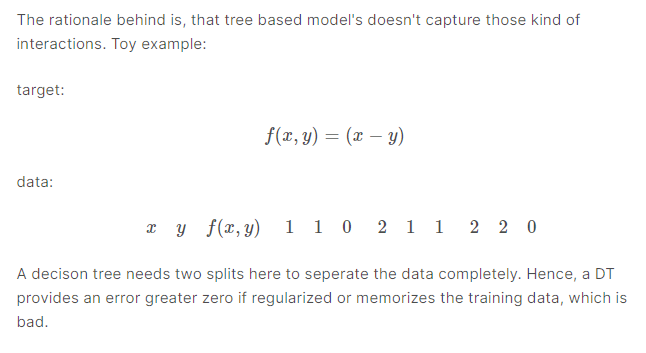

In [38]:


im=Image.open('pic1.PNG')
display(im)

Опять таки, делал он это все бутстрапом признаков используя свою библиотеку, возможности которой в этом плане пока не доступны. По-этому попробую реализовать принцип самостоятельно.

Но сначала опять хочу обратить внимание на параметр 'gain', который в xgb.feature_importance_ по умолчанию не доступен (там возвращается 'weight')

Поэтому используем несколько приемов, чтобы вытянуть его. Сначала опять обучим модель:

In [40]:
X=train.iloc[:10000,:]
Y=y_train[:10000]
clf=xgb.XGBClassifier(xgb_params=xgb_params)
clf.fit(X, Y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None,
              xgb_params={'colsample_bytree': 0.8, 'eta': 0.0275,
                          'eval_metric': 'auc', 'max_depth': 5, 'nthread': 22,
                          'num_parallel_tree': 7,
                          'objective': 'binary:logitraw', 'seed': 0,
                          'silent': 1, 'subsample': 0.85})

In [42]:
k = clf.get_booster().trees_to_dataframe()
group = k[k['Feature']!='Leaf'].groupby('Feature').agg(fscore = ('Gain', 'count'),
                                                       feature_importance_gain = ('Gain', 'mean'))
group

,fscore,feature_importance_gain
Feature,,
CoverageField11A,23,4.375525
CoverageField11B,24,4.092871
CoverageField1A,7,1.422412
CoverageField1B,1,5.231568
CoverageField2A,7,2.666376
...,...,...
SalesField7,19,1.977527
SalesField8,65,1.915175
SalesField9,1,0.809745


И отсюда уже можно получить значения  'gain'.

In [43]:
X.shape

(10000, 301)

Единственно, что важно, признаки, значение которых равно нулю в этой табличке не отражаются, поэтому их и меньше чем изначальном датасете. Чтобы показать их, нужно выполнить следующие действие:

In [44]:
X.columns[[ x not in k['Feature'].unique() for x in X.columns]]

Index(['CoverageField5B', 'CoverageField6B', 'SalesField14', 'PersonalField6',
       'PersonalField7', 'PersonalField8', 'PersonalField23',
       'PersonalField24', 'PersonalField25', 'PersonalField30',
       'PersonalField32', 'PersonalField33', 'PersonalField34',
       'PersonalField35', 'PersonalField36', 'PersonalField37',
       'PersonalField38', 'PersonalField39', 'PersonalField40',
       'PersonalField41', 'PersonalField42', 'PersonalField43',
       'PersonalField45', 'PersonalField48', 'PersonalField49',
       'PersonalField50', 'PersonalField51', 'PersonalField52',
       'PersonalField53', 'PersonalField54', 'PersonalField55',
       'PersonalField56', 'PersonalField57', 'PersonalField58',
       'PersonalField59', 'PersonalField60', 'PersonalField61',
       'PersonalField62', 'PersonalField63', 'PersonalField64',
       'PersonalField65', 'PersonalField66', 'PersonalField67',
       'PersonalField68', 'PersonalField69', 'PersonalField70',
       'PersonalField71', '

Далее, пишу программу бустинга признаков для 2-way взаимодействия:

In [45]:
# it - количество итераций
# size - количество пар-признаков образующих новый признак,
# рандомно выбираемых из списка пар признаков
# xtrain,ytrain - загружаемые данные
def interactions(xtrain,ytrain,it,size):
    # составляю список пар признаков
    lst2way=list(combinations(xtrain.columns, 2))
    df=pd.DataFrame()
    # создаю словарь, который буду заполнять значениями - пара признаков: их значимость
    fdict={}
    for i in range(it):
        # генерирую случайным образом индексы из списка пар признаков
        var=np.random.randint(0,len(lst2way),size=size)
        for ix in var:
            # значение нового признака будет равно разности двух выбранных
            series = xtrain[lst2way[ix][0]]-xtrain[lst2way[ix][1]]
            # генерирую имя для этого признака и добавляю его в датасет
            name=lst2way[ix][0]+' '+lst2way[ix][1]
            df[name]=series
        # тренирую классификатор на полученном датасете
        clf=xgb.XGBClassifier()
        data1 = df
        data2 = ytrain
        clf.fit(data1, data2)
        # извлекаю важность признака
        k = clf.get_booster().trees_to_dataframe()
        group = k[k['Feature']!='Leaf'].groupby('Feature').agg(fscore = ('Gain', 'count'),
                                                       feature_importance_gain = ('Gain', 'mean'))
        col_pairs=list(group.index)
        impotances=list(group.feature_importance_gain)
        # добавляю признак и его важность в словарь
        for n, x in zip(impotances, col_pairs):
            x=tuple(x.split())
            # если признак уже есть в словаре, добавляю счетчик, 
            # чтобы потом посчитать его среднее значение
            if x in fdict:
                fdict[x]=(n+fdict.get(x)[0],
                                             fdict.get(x)[1]+1)
            else:   
                fdict[x]=(n,1)
    # считаю средние значения пар признаков
    for k in fdict.keys():
        fdict[k]=fdict.get(k)[0]/(fdict.get(k)[1])
    # сортирую признаки
    fdict_sorted={k: v for k, v in sorted(fdict.items(), 
                    key=lambda item: item[1], reverse=True)}
    # вывожу 28 пар самых значимых
    list2way=list(fdict_sorted)[:28]
    return list2way

In [46]:
X=train.iloc[:10000,:]
Y=y_train[:10000]
res=interactions(X,Y,10,40)

In [48]:
print('28 пар значимых признаков: ',res)

28 пар значимых признаков:  [('PersonalField1', 'PersonalField66'), ('GeographicField12A', 'GeographicField64'), ('SalesField5', 'PropertyField5'), ('PersonalField24', 'GeographicField12A'), ('PersonalField10A', 'PersonalField57'), ('PropertyField29', 'GeographicField22B'), ('PersonalField2', 'PropertyField36'), ('SalesField1A', 'PropertyField36'), ('SalesField1A', 'PropertyField28'), ('PersonalField67', 'PersonalField82'), ('PersonalField44', 'PropertyField36'), ('PersonalField27', 'GeographicField6A'), ('PropertyField34', 'GeographicField22A'), ('PersonalField1', 'PersonalField42'), ('PersonalField22', 'PropertyField36'), ('PersonalField29', 'PropertyField29'), ('CoverageField11A', 'PropertyField30'), ('PersonalField23', 'PersonalField81'), ('PersonalField10A', 'PropertyField11B'), ('PersonalField65', 'PersonalField81'), ('SalesField1A', 'PropertyField1B'), ('SalesField2A', 'GeographicField37A'), ('PersonalField1', 'PersonalField60'), ('PersonalField9', 'PropertyField36'), ('Personal

Таким же образом, немного модифицировав программу, можно посчитать комбинации признаков для 3-way и 4-way взаимодействия.
Здесь я этот шаг опущу и вернусь обратно к работе автора.

# Работа с признаками 2

Итак, выделим списки признаков, найденные автором и параметры модели:

In [50]:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': .85,
    'eta': 0.0275,
    'objective': 'binary:logitraw',
    'num_parallel_tree': 7,
    'max_depth': 5,
    'nthread': 22,
    'eval_metric': 'auc',
}

top111 = ['Field12', 'PersonalField52', 'PersonalField80', 'PersonalField44', 'Field9',
          'PropertyField7', 'PropertyField12', 'CoverageField5B', 'PersonalField42', 'PersonalField45',
          'PersonalField81', 'PropertyField8', 'PersonalField79', 'GeographicField45B', 'PropertyField22',
          'PersonalField75', 'PersonalField31', 'PropertyField19', 'PropertyField31', 'GeographicField11A',
          'PersonalField23', 'GeographicField21B', 'PersonalField4A', 'Field10', 'GeographicField16B',
          'GeographicField20A', 'PersonalField25', 'PersonalField4B', 'PropertyField3', 'GeographicField17A',
          'GeographicField59B', 'GeographicField7B', 'GeographicField8A', 'Year', 'GeographicField6B',
          'PersonalField14',
          'GeographicField45A', 'GeographicField14B', 'SalesField12', 'CoverageField11A', 'CoverageField5A', 'Month',
          'PropertyField33', 'PersonalField5', 'CoverageField11B', 'GeographicField11B', 'GeographicField23B',
          'PropertyField39B', 'CoverageField3A', 'GeographicField1B', 'GeographicField17B', 'PropertyField39A',
          'GeographicField41B', 'CoverageField6A', 'SalesField9', 'PersonalField16', 'PersonalField26',
          'PropertyField24A', 'Field8', 'GeographicField28A', 'CoverageField3B', 'SalesField2A', 'GeographicField19B',
          'GeographicField43A', 'PropertyField16B', 'PropertyField16A', 'PropertyField1B', 'CoverageField1B',
          'PropertyField1A', 'GeographicField48B', 'PersonalField11', 'CoverageField1A', 'PersonalField15',
          'GeographicField5B', 'PropertyField34', 'CoverageField8', 'PersonalField82', 'SalesField2B',
          'PropertyField35', 'CoverageField2B', 'SalesField10', 'PropertyField21A', 'SalesField3', 'CoverageField9',
          'SalesField7', 'Weekday', 'PersonalField13', 'PropertyField21B', 'SalesField6', 'SalesField1A',
          'PersonalField9', 'SalesField4', 'PersonalField12', 'PersonalField27', 'PersonalField10B', 'Field7',
          'SalesField1B', 'PersonalField84', 'PersonalField2', 'PersonalField1', 'SalesField5', 'PersonalField10A',
          'PropertyField37', 'PropertyField29', 'GeographicField4B', 'PropertyField2B', 'GeographicField1A',
          'GeographicField61B', 'Field11', 'PersonalField76', 'PropertyField30']

drop_out = ['GeographicField19B', 'PropertyField7', 'GeographicField17A', 'GeographicField28A',
            'GeographicField21B', 'GeographicField7B', 'CoverageField11B', 'GeographicField6B', 'GeographicField45A',
            'PersonalField25', 'Month', 'CoverageField5A', 'GeographicField8A', 'GeographicField1B',
            'CoverageField6A_CoverageField6B', 'PersonalField23', 'Field11', 'PropertyField2B', 'SalesField12',
            'GeographicField41B',
            'PropertyField16A', 'Field10', 'PropertyField3', 'PropertyField16B', 'GeographicField1A',
            'GeographicField20A', 'PersonalField81', 'GeographicField16B', 'GeographicField59B', 'PersonalField79',
            'CoverageField1A_CoverageField3A', 'CoverageField3B_CoverageField4B', 'PropertyField22',
            'GeographicField61B',
            'CoverageField3A_PropertyField21A', 'PropertyField12', 'CoverageField2A_CoverageField3A',
            'CoverageField2B_CoverageField3B', 'PropertyField8', 'PropertyField30', 'GeographicField14B',
            'PersonalField31',
            'PropertyField21A', 'CoverageField3A_CoverageField4A', 'PropertyField31', 'CoverageField11A',
            'PropertyField19', 'GeographicField45B', 'CoverageField1A', 'PersonalField75',
            'GeographicField8A_GeographicField13A', 'CoverageField3B_PropertyField21B',
            'CoverageField1B_CoverageField3B', 'GeographicField6A_GeographicField13A', 'CoverageField5B',
            'PersonalField42', 'PersonalField45', 'PersonalField76', 'GeographicField6A_GeographicField8A',
            'PersonalField80', 'Field9', 'CoverageField3A', 'CoverageField3B',
            'GeographicField8A_GeographicField11A', 'GeographicField11A_GeographicField13A',
            'GeographicField4B',
            'CoverageField2B', 'Field12', 'PropertyField21B', 'CoverageField1B', 'PersonalField44',
            'GeographicField6A_GeographicField11A', 'PersonalField52']

interactions2way = [
    ("CoverageField1B", "PropertyField21B"),
    ("GeographicField6A", "GeographicField8A"),
    ("GeographicField6A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField13A"),
    ("GeographicField11A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField11A"),
    ("GeographicField6A", "GeographicField11A"),
    ("CoverageField6A", "CoverageField6B"),
    ("CoverageField3A", "CoverageField4A"),
    ("CoverageField2B", "CoverageField3B"),
    ("CoverageField1A", "CoverageField3A"),
    ("CoverageField3B", "CoverageField4B"),
    ("CoverageField2A", "CoverageField3A"),
    ("CoverageField1B", "CoverageField3B"),
    ("CoverageField3B", "PropertyField21B"),
    ("CoverageField3A", "PropertyField21A"),
    ("CoverageField1B", "PropertyField16B"),
    ("Weekday", "SalesField7"),
    ("PersonalField9", "CoverageField6B"),
    ("PersonalField12", "CoverageField6A"),
    ("PropertyField16B", "PropertyField21A"),
    ("PersonalField12", "Field8"),
    ("PropertyField32", "PersonalField9"),
    ("Field6", "CoverageField6A"),
    ("PersonalField12", "CoverageField6A"),
    ("CoverageField6A", "PropertyField34"),
    ("PersonalField33", "PropertyField8"),
    ("CoverageField2A", "CoverageField3B")
]

interactions3way = [('PersonalField23', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField3A', 'PersonalField63', 'PropertyField21A'),
                    ('CoverageField3A', 'CoverageField4A', 'PersonalField76'),
                    ('CoverageField3A', 'CoverageField4A', 'GeographicField62A'),
                    ('CoverageField6A', 'PersonalField69', 'PersonalField9'),
                    ('CoverageField6A', 'PersonalField71', 'PersonalField9'),
                    ('GeographicField10B', 'GeographicField13A', 'PersonalField9'),
                    ('GeographicField8A', 'PersonalField71', 'PersonalField9'),
                    ('CoverageField2B', 'PersonalField75', 'PropertyField16B'),
                    ('CoverageField6A', 'PersonalField49', 'PropertyField29'),
                    ('CoverageField4B', 'PersonalField39', 'PropertyField16B'),
                    ('CoverageField11B', 'PersonalField6', 'SalesField2B'),
                    ('CoverageField11B', 'PersonalField36', 'SalesField2B'),
                    ('CoverageField2B', 'PropertyField16B', 'PropertyField8'),
                    ('CoverageField3A', 'GeographicField21A', 'PropertyField21B'),
                    ('GeographicField11A', 'PersonalField48', 'PersonalField9'),
                    ('CoverageField11B', 'PersonalField26', 'SalesField2B'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField61'),
                    ('CoverageField1A', 'PropertyField16A', 'PropertyField36'),
                    ('PersonalField9', 'PropertyField10', 'PropertyField32'),
                    ('GeographicField11A', 'GeographicField62A', 'PersonalField12'),
                    ('Field10', 'PersonalField9', 'PropertyField34'),
                    ('CoverageField2B', 'CoverageField3A', 'PersonalField8'),
                    ('Field11', 'PropertyField34', 'SalesField6'),
                    ('PersonalField19', 'PersonalField60', 'PropertyField8')]

interactions4way = [('Field8', 'PersonalField12', 'PersonalField75', 'PropertyField37'),
                    ('CoverageField6A', 'PersonalField12', 'PropertyField37', 'PropertyField8'),
                    ('Field8', 'PersonalField9', 'PropertyField3', 'PropertyField37'),
                    ('CoverageField6A', 'Field8', 'PersonalField84', 'PersonalField9'),
                    ('CoverageField8', 'PersonalField12', 'PersonalField80', 'PropertyField37'),
                    ('CoverageField8', 'Field8', 'PersonalField12', 'PersonalField84'),
                    ('CoverageField5A', 'GeographicField11A', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField1B', 'CoverageField3B', 'CoverageField5A', 'PropertyField22'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField82', 'PropertyField19'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField11', 'PropertyField19'),
                    ('CoverageField5A', 'Field8', 'PersonalField12', 'PersonalField42'),
                    ('CoverageField6A', 'Field11', 'PersonalField9', 'PropertyField12'),
                    ('CoverageField6A', 'CoverageField8', 'PropertyField35', 'SalesField3'),
                    ('CoverageField3A', 'PersonalField82', 'PropertyField21A', 'Year'),
                    ('CoverageField1B', 'CoverageField3B', 'PersonalField42', 'PropertyField8'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField1', 'PropertyField16A'),
                    ('CoverageField1B', 'CoverageField3B', 'PropertyField22', 'PropertyField8'),
                    ('CoverageField6A', 'PersonalField45', 'PersonalField9', 'PropertyField29'),
                    ('CoverageField5A', 'PersonalField1', 'PropertyField35', 'SalesField3'),
                    ('CoverageField1A', 'CoverageField3A', 'Field12', 'PersonalField27'),
                    ('CoverageField5A', 'CoverageField8', 'Field11', 'PropertyField29'),
                    ('CoverageField3B', 'PersonalField25', 'PersonalField45', 'PropertyField21B'),
                    ('CoverageField2B', 'CoverageField3B', 'GeographicField17A', 'PersonalField5'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField75', 'Year'),
                    ('Field11', 'PersonalField12', 'PersonalField25', 'PropertyField30')]


In [51]:
# здесь автор удаляет повторяющиеся поля в разных списках и подготавливает их
# для генерации новых признаков - разности полей
interactions2way_list = list(np.unique(list(chain(*interactions2way))))
interactions3way_list = list(np.unique(list(chain(*interactions3way))))
interactions4way_list = list(np.unique(list(chain(*interactions4way))))

interactions_list = interactions2way_list + interactions3way_list + interactions4way_list
tmp_features = list(np.setdiff1d(interactions_list, top111))

tc_features = []


In [52]:
features = list(train.columns)
features = np.intersect1d(features, top111 + tmp_features)

x_train = train[features].copy()
x_test = test[features].copy()
# создание признака подсчета пропущенных значений
x_train['NaNCount'] = x_train.apply(lambda x: np.sum(x == -1), axis=1)
x_test['NaNCount'] = x_test.apply(lambda x: np.sum(x == -1), axis=1)

In [53]:
# создание взаимодействующих признаков и удаление не нужных
for A, B in interactions2way:
        feat = "_".join([A, B])
        x_train[feat] = x_train[A] - x_train[B]
        x_test[feat] = x_test[A] - x_test[B]

for A, B, C in interactions3way:
    feat = "_".join([A, B, C])
    tc_features += [feat]
    x_train[feat] = x_train[A] - x_train[B] - x_train[C]
    x_test[feat] = x_test[A] - x_test[B] - x_test[C]

for A, B, C, D in interactions4way:
    feat = "_".join([A, B, C, D])
    tc_features += [feat]
    x_train[feat] = x_train[A] - x_train[B] - x_train[C] - x_train[D]
    x_test[feat] = x_test[A] - x_test[B] - x_test[C] - x_test[D]

x_train.drop(tmp_features, axis=1, inplace=True)
x_test.drop(tmp_features, axis=1, inplace=True)

x_train.drop(drop_out[-25:], axis=1, inplace=True)
x_test.drop(drop_out[-25:], axis=1, inplace=True)

In [56]:

print (x_train.shape, x_test.shape)

(260753, 164) (173836, 164)


# Соединяю все вместе и обучаю модель

In [58]:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': .85,
    'eta': 0.0275,
    'objective': 'binary:logitraw',
    'num_parallel_tree': 7,
    'max_depth': 5,
    'nthread': 22,
    'eval_metric': 'auc',
}

top111 = ['Field12', 'PersonalField52', 'PersonalField80', 'PersonalField44', 'Field9',
          'PropertyField7', 'PropertyField12', 'CoverageField5B', 'PersonalField42', 'PersonalField45',
          'PersonalField81', 'PropertyField8', 'PersonalField79', 'GeographicField45B', 'PropertyField22',
          'PersonalField75', 'PersonalField31', 'PropertyField19', 'PropertyField31', 'GeographicField11A',
          'PersonalField23', 'GeographicField21B', 'PersonalField4A', 'Field10', 'GeographicField16B',
          'GeographicField20A', 'PersonalField25', 'PersonalField4B', 'PropertyField3', 'GeographicField17A',
          'GeographicField59B', 'GeographicField7B', 'GeographicField8A', 'Year', 'GeographicField6B',
          'PersonalField14',
          'GeographicField45A', 'GeographicField14B', 'SalesField12', 'CoverageField11A', 'CoverageField5A', 'Month',
          'PropertyField33', 'PersonalField5', 'CoverageField11B', 'GeographicField11B', 'GeographicField23B',
          'PropertyField39B', 'CoverageField3A', 'GeographicField1B', 'GeographicField17B', 'PropertyField39A',
          'GeographicField41B', 'CoverageField6A', 'SalesField9', 'PersonalField16', 'PersonalField26',
          'PropertyField24A', 'Field8', 'GeographicField28A', 'CoverageField3B', 'SalesField2A', 'GeographicField19B',
          'GeographicField43A', 'PropertyField16B', 'PropertyField16A', 'PropertyField1B', 'CoverageField1B',
          'PropertyField1A', 'GeographicField48B', 'PersonalField11', 'CoverageField1A', 'PersonalField15',
          'GeographicField5B', 'PropertyField34', 'CoverageField8', 'PersonalField82', 'SalesField2B',
          'PropertyField35', 'CoverageField2B', 'SalesField10', 'PropertyField21A', 'SalesField3', 'CoverageField9',
          'SalesField7', 'Weekday', 'PersonalField13', 'PropertyField21B', 'SalesField6', 'SalesField1A',
          'PersonalField9', 'SalesField4', 'PersonalField12', 'PersonalField27', 'PersonalField10B', 'Field7',
          'SalesField1B', 'PersonalField84', 'PersonalField2', 'PersonalField1', 'SalesField5', 'PersonalField10A',
          'PropertyField37', 'PropertyField29', 'GeographicField4B', 'PropertyField2B', 'GeographicField1A',
          'GeographicField61B', 'Field11', 'PersonalField76', 'PropertyField30']

drop_out = ['GeographicField19B', 'PropertyField7', 'GeographicField17A', 'GeographicField28A',
            'GeographicField21B', 'GeographicField7B', 'CoverageField11B', 'GeographicField6B', 'GeographicField45A',
            'PersonalField25', 'Month', 'CoverageField5A', 'GeographicField8A', 'GeographicField1B',
            'CoverageField6A_CoverageField6B', 'PersonalField23', 'Field11', 'PropertyField2B', 'SalesField12',
            'GeographicField41B',
            'PropertyField16A', 'Field10', 'PropertyField3', 'PropertyField16B', 'GeographicField1A',
            'GeographicField20A', 'PersonalField81', 'GeographicField16B', 'GeographicField59B', 'PersonalField79',
            'CoverageField1A_CoverageField3A', 'CoverageField3B_CoverageField4B', 'PropertyField22',
            'GeographicField61B',
            'CoverageField3A_PropertyField21A', 'PropertyField12', 'CoverageField2A_CoverageField3A',
            'CoverageField2B_CoverageField3B', 'PropertyField8', 'PropertyField30', 'GeographicField14B',
            'PersonalField31',
            'PropertyField21A', 'CoverageField3A_CoverageField4A', 'PropertyField31', 'CoverageField11A',
            'PropertyField19', 'GeographicField45B', 'CoverageField1A', 'PersonalField75',
            'GeographicField8A_GeographicField13A', 'CoverageField3B_PropertyField21B',
            'CoverageField1B_CoverageField3B', 'GeographicField6A_GeographicField13A', 'CoverageField5B',
            'PersonalField42', 'PersonalField45', 'PersonalField76', 'GeographicField6A_GeographicField8A',
            'PersonalField80', 'Field9', 'CoverageField3A', 'CoverageField3B',
            'GeographicField8A_GeographicField11A', 'GeographicField11A_GeographicField13A',
            'GeographicField4B',
            'CoverageField2B', 'Field12', 'PropertyField21B', 'CoverageField1B', 'PersonalField44',
            'GeographicField6A_GeographicField11A', 'PersonalField52']

interactions2way = [
    ("CoverageField1B", "PropertyField21B"),
    ("GeographicField6A", "GeographicField8A"),
    ("GeographicField6A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField13A"),
    ("GeographicField11A", "GeographicField13A"),
    ("GeographicField8A", "GeographicField11A"),
    ("GeographicField6A", "GeographicField11A"),
    ("CoverageField6A", "CoverageField6B"),
    ("CoverageField3A", "CoverageField4A"),
    ("CoverageField2B", "CoverageField3B"),
    ("CoverageField1A", "CoverageField3A"),
    ("CoverageField3B", "CoverageField4B"),
    ("CoverageField2A", "CoverageField3A"),
    ("CoverageField1B", "CoverageField3B"),
    ("CoverageField3B", "PropertyField21B"),
    ("CoverageField3A", "PropertyField21A"),
    ("CoverageField1B", "PropertyField16B"),
    ("Weekday", "SalesField7"),
    ("PersonalField9", "CoverageField6B"),
    ("PersonalField12", "CoverageField6A"),
    ("PropertyField16B", "PropertyField21A"),
    ("PersonalField12", "Field8"),
    ("PropertyField32", "PersonalField9"),
    ("Field6", "CoverageField6A"),
    ("PersonalField12", "CoverageField6A"),
    ("CoverageField6A", "PropertyField34"),
    ("PersonalField33", "PropertyField8"),
    ("CoverageField2A", "CoverageField3B")
]

interactions3way = [('PersonalField23', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField3A', 'PersonalField63', 'PropertyField21A'),
                    ('CoverageField3A', 'CoverageField4A', 'PersonalField76'),
                    ('CoverageField3A', 'CoverageField4A', 'GeographicField62A'),
                    ('CoverageField6A', 'PersonalField69', 'PersonalField9'),
                    ('CoverageField6A', 'PersonalField71', 'PersonalField9'),
                    ('GeographicField10B', 'GeographicField13A', 'PersonalField9'),
                    ('GeographicField8A', 'PersonalField71', 'PersonalField9'),
                    ('CoverageField2B', 'PersonalField75', 'PropertyField16B'),
                    ('CoverageField6A', 'PersonalField49', 'PropertyField29'),
                    ('CoverageField4B', 'PersonalField39', 'PropertyField16B'),
                    ('CoverageField11B', 'PersonalField6', 'SalesField2B'),
                    ('CoverageField11B', 'PersonalField36', 'SalesField2B'),
                    ('CoverageField2B', 'PropertyField16B', 'PropertyField8'),
                    ('CoverageField3A', 'GeographicField21A', 'PropertyField21B'),
                    ('GeographicField11A', 'PersonalField48', 'PersonalField9'),
                    ('CoverageField11B', 'PersonalField26', 'SalesField2B'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField61'),
                    ('CoverageField1A', 'PropertyField16A', 'PropertyField36'),
                    ('PersonalField9', 'PropertyField10', 'PropertyField32'),
                    ('GeographicField11A', 'GeographicField62A', 'PersonalField12'),
                    ('Field10', 'PersonalField9', 'PropertyField34'),
                    ('CoverageField2B', 'CoverageField3A', 'PersonalField8'),
                    ('Field11', 'PropertyField34', 'SalesField6'),
                    ('PersonalField19', 'PersonalField60', 'PropertyField8')]

interactions4way = [('Field8', 'PersonalField12', 'PersonalField75', 'PropertyField37'),
                    ('CoverageField6A', 'PersonalField12', 'PropertyField37', 'PropertyField8'),
                    ('Field8', 'PersonalField9', 'PropertyField3', 'PropertyField37'),
                    ('CoverageField6A', 'Field8', 'PersonalField84', 'PersonalField9'),
                    ('CoverageField8', 'PersonalField12', 'PersonalField80', 'PropertyField37'),
                    ('CoverageField8', 'Field8', 'PersonalField12', 'PersonalField84'),
                    ('CoverageField5A', 'GeographicField11A', 'PersonalField9', 'PropertyField37'),
                    ('CoverageField1B', 'CoverageField3B', 'CoverageField5A', 'PropertyField22'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField82', 'PropertyField19'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField11', 'PropertyField19'),
                    ('CoverageField5A', 'Field8', 'PersonalField12', 'PersonalField42'),
                    ('CoverageField6A', 'Field11', 'PersonalField9', 'PropertyField12'),
                    ('CoverageField6A', 'CoverageField8', 'PropertyField35', 'SalesField3'),
                    ('CoverageField3A', 'PersonalField82', 'PropertyField21A', 'Year'),
                    ('CoverageField1B', 'CoverageField3B', 'PersonalField42', 'PropertyField8'),
                    ('CoverageField1B', 'CoverageField3A', 'PersonalField1', 'PropertyField16A'),
                    ('CoverageField1B', 'CoverageField3B', 'PropertyField22', 'PropertyField8'),
                    ('CoverageField6A', 'PersonalField45', 'PersonalField9', 'PropertyField29'),
                    ('CoverageField5A', 'PersonalField1', 'PropertyField35', 'SalesField3'),
                    ('CoverageField1A', 'CoverageField3A', 'Field12', 'PersonalField27'),
                    ('CoverageField5A', 'CoverageField8', 'Field11', 'PropertyField29'),
                    ('CoverageField3B', 'PersonalField25', 'PersonalField45', 'PropertyField21B'),
                    ('CoverageField2B', 'CoverageField3B', 'GeographicField17A', 'PersonalField5'),
                    ('CoverageField1A', 'CoverageField3A', 'PersonalField75', 'Year'),
                    ('Field11', 'PersonalField12', 'PersonalField25', 'PropertyField30')]


def get_data():
    global tc_features

    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)

    y_train = train.QuoteConversion_Flag

    train = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
    test = test.drop('QuoteNumber', axis=1)

    ntrain = train.shape[0]

    train_test = pd.concat((train, test), axis=0)

    train_test['Date'] = pd.to_datetime(train_test['Original_Quote_Date'])

    train_test['Year'] = train_test['Date'].dt.year
    train_test['Month'] = train_test['Date'].dt.month
    train_test['Day'] = train_test['Date'].dt.day
    train_test['Weekday'] = train_test['Date'].dt.dayofweek

    train_test['Field10'] = train_test['Field10'].apply(lambda x: x.replace(',', '')).astype(np.int32)
    train_test['PropertyField37'] = train_test['PropertyField37'].apply(lambda x: -1 if x == ' ' else x)
    train_test['GeographicField63'] = train_test['GeographicField63'].apply(lambda x: -1 if x == ' ' else x)

    train_test = train_test.drop(['Date', 'Original_Quote_Date'], axis=1)
    train_test = train_test.fillna(-1)

    categoricals = [x for x in train_test.columns if train_test[x].dtype == 'object']

    for c in categoricals:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_test[c].values))
        train_test[c] = lbl.transform(list(train_test[c].values))

    train = train_test.iloc[:ntrain, :].copy().reset_index(drop=True)
    test = train_test.iloc[ntrain:, :].copy().reset_index(drop=True)

    features = list(train.columns)
    features = np.intersect1d(features, top111 + tmp_features)

    x_train = train[features].copy()
    x_test = test[features].copy()

    x_train['NaNCount'] = x_train.apply(lambda x: np.sum(x == -1), axis=1)
    x_test['NaNCount'] = x_test.apply(lambda x: np.sum(x == -1), axis=1)

    for A, B in interactions2way:
        feat = "_".join([A, B])
        x_train[feat] = x_train[A] - x_train[B]
        x_test[feat] = x_test[A] - x_test[B]

    for A, B, C in interactions3way:
        feat = "_".join([A, B, C])
        tc_features += [feat]
        x_train[feat] = x_train[A] - x_train[B] - x_train[C]
        x_test[feat] = x_test[A] - x_test[B] - x_test[C]

    for A, B, C, D in interactions4way:
        feat = "_".join([A, B, C, D])
        tc_features += [feat]
        x_train[feat] = x_train[A] - x_train[B] - x_train[C] - x_train[D]
        x_test[feat] = x_test[A] - x_test[B] - x_test[C] - x_test[D]

    x_train.drop(tmp_features, axis=1, inplace=True)
    x_test.drop(tmp_features, axis=1, inplace=True)

    x_train.drop(drop_out[-25:], axis=1, inplace=True)
    x_test.drop(drop_out[-25:], axis=1, inplace=True)

    return np.array(x_train), np.array(y_train), np.array(x_test)




In [59]:
x_train, y_train, x_test = get_data()
print (x_train.shape, x_test.shape)


(260753, 164) (173836, 164)


In [60]:
x_train_tc = x_train.copy()
ntcfeat = len(tc_features)

x_train[:, -ntcfeat:] = 0

ntrain = x_train.shape[0]
best_nrounds = 2500

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtrain_tc = xgb.DMatrix(x_train_tc, label=y_train)

gbdt = xgb.train(xgb_params, dtrain, best_nrounds - 100)
xgb_params['eta'] = 0.01

gbdt = xgb.train(xgb_params, dtrain_tc, 300, xgb_model=gbdt)

dtest = xgb.DMatrix(x_test)
dtest = xgb.DMatrix(x_test)
submission = pd.read_csv(sample_submission)
submission.iloc[:, 1] = gbdt.predict(dtest).reshape((-1, 1))
submission.to_csv(submission_filename, index=False)

# Проверяю результат

In [63]:
!kaggle competitions submit -c homesite-quote-conversion -f god_of_overfitting_spare_us.csv -m spare_us

Successfully submitted to Homesite Quote Conversion



  0%|          | 0.00/4.31M [00:00<?, ?B/s]
  8%|8         | 368k/4.31M [00:00<00:01, 3.53MB/s]
 38%|###7      | 1.63M/4.31M [00:00<00:00, 4.52MB/s]
 48%|####8     | 2.08M/4.31M [00:01<00:02, 828kB/s] 
 74%|#######4  | 3.21M/4.31M [00:01<00:01, 1.15MB/s]
 99%|#########8| 4.27M/4.31M [00:02<00:00, 1.57MB/s]
100%|##########| 4.31M/4.31M [00:03<00:00, 1.21MB/s]


In [64]:
!kaggle competitions submissions homesite-quote-conversion

fileName                         date                 description     status    publicScore  privateScore  
-------------------------------  -------------------  --------------  --------  -----------  ------------  
god_of_overfitting_spare_us.csv  2021-01-03 18:20:09  spare_us        complete  0.96928      0.96897       
god_of_overfitting_spare_us.csv  2021-01-02 15:24:21  spare_us        complete  0.96928      0.96897       
xgb_benchmark_5.csv              2021-01-02 09:51:38  xgb_benchmark   complete  0.96057      0.95992       
xgb_benchmark.csv                2021-01-02 08:25:12  xgb_benchmark   complete  0.96057      0.95992       
xgb_benchmark.csv                2021-01-02 08:21:42  xgb_benchmark   complete  0.96057      0.95992       
xgbr_benchmark.csv               2020-12-31 16:21:18  xgbr_benchmark  complete  0.73950      0.73853       
xgb_benchmark.csv                2020-12-31 05:54:28  xgb_benchmark   complete  0.96181      0.96115       
xgb_benchmark.csv           

Итак, полученный результат: 0.96928